In [1]:
## load the model for CIFAR-10
import numpy as np
import torch
import torch.nn as nn
import math
from torch.nn import functional as F

In [2]:
# model of Neural-GODE
int_T = 1
spline_k = 1
spline_n = 8
tol = 1e-4
downsampling_method = 'conv'
num_equations = 64
ode_step_size = 0.05
gpu=0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

def basisF(u, k, i, t):     # the basis function based on recursive formula
    if k == 0:
        return 1.0 if t[i] <= u < t[i+1] else 0.0
    if t[i+k] == t[i]:
        s1 = 0.0
    else:
        s1 = (u - t[i])/(t[i+k] - t[i]) * basisF(u, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        s2 = 0.0
    else:
        s2 = (t[i+k+1] - u)/(t[i+k+1] - t[i+1]) * basisF(u, k-1, i+1, t)
    return s1 + s2

tt = np.append(np.arange(0,int_T, int_T/(spline_k + spline_n)),[int_T]) # knots vector
ele_spline = [[basisF(t, spline_k, i, tt) for i in range(spline_n)] for t in np.arange(0,4,0.001)]

def norm(dim): # apply a group normalization over a mini-batch of input; 
    #The input channels are separated into num_groups groups, each containing num_channels/num_groups channels.
    return nn.GroupNorm(min(32, dim), dim)  # number of groups: min(32, dim); number of channels: dim
    
class SplineLinear(nn.Module):
    
    def __init__(self, dim, spline_n=3,step_size=0.1):
        super(SplineLinear,self).__init__()                 # inherit the basic module
        
        # parameters
        self.dim = dim
        self.n = spline_n
        self.step_size = step_size
           
        # trainable coefficients of the spline function
        c1 = torch.Tensor(self.dim,self.dim, 3, 3, self.n)
        self.c1 = torch.nn.Parameter(c1)
        nn.init.kaiming_uniform_(self.c1, a= math.sqrt(3))

    
    def BS(self, t, c):     # calculate basis function
        t_index = int(torch.round(t/0.001).item())
        #print(t)
        Tele_spline = torch.Tensor(ele_spline[t_index]).to(device = device)
        BS_fvalue = torch.mul(c,Tele_spline)
        BS_fvalue = torch.sum(BS_fvalue,4)
        return BS_fvalue
    
    def spline_conv(self,t,x):    
        weights = self.BS(t, self.c1) # b-spline function as the cnn weights
        #conv_fun = nn.Conv2d(self.dim, self.dim, 3, stride=1, padding=1, bias=False)
        #with torch.no_grad():
        #    conv_fun.weight = nn.Parameter(weights)   
        return F.conv2d(x,weights,stride=1,padding=1,bias=None)
    
    def forward(self,t,x):
        out = self.spline_conv(t,x)
        return out
            
        
class ODEfunc(nn.Module):
    def __init__(self,dim,spline_n,step_size):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu1 = nn.ReLU(inplace=True)
        self.spline_linear1 = SplineLinear(dim,spline_n,step_size)
        self.norm2 = norm(dim)
        self.relu2 = nn.ReLU(inplace=True)
        self.spline_linear2 = SplineLinear(dim,spline_n,step_size)
        
        self.nfe = 0                          # number of function evaluation
        
    def forward(self,t,x):
        #print(x.shape)
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu1(out)
        out = self.spline_linear1(t,out)
        out = self.norm2(out)
        out = self.relu2(out)
        out = self.spline_linear2(t,out)
  
        return out
        

class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, int_T]).float()  # integrate from 0 to int_T

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        #print(self.integration_time)
        #out = odeint(self.odefunc, x, self.integration_time, rtol=args.tol, atol=args.tol, method='dopri5') # the ODE system
        out = odeint(self.odefunc, x, self.integration_time, rtol=tol, atol=tol, method = 'euler', 
                     options=dict(step_size=ode_step_size)) # the ODE system
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value

if downsampling_method == 'conv':
    downsampling_layers = [
            nn.Conv2d(3, 64, 3, 1),   # in_channels = 1, out_channels = 64, filter_size = 3, stride = 1, outdim = 126
            # number_parameters = 3*3*64+64 = 640
            norm(64),                # group normalization
            # number_parameters = 64*2 = 128
            nn.ReLU(inplace=True),
            # number_parameters = 0
            nn.Conv2d(64, 64, 4, 2, 1), #in_channels = 64, out_channels = 64, filter_size =4, stride = 2, padding = 1
            # number_parameters = 4*4*64 (input_channels)*64+64 = 65600, output_dim = 63
            norm(64),
            # number_parameters = 64*2
            nn.ReLU(inplace=True),
            # number_parameters = 0
            nn.Conv2d(64, 64, 4, 2, 1), # output: 64 filter map with dimension 
            # number_parameters = 65600
            #norm(64),
            #nn.ReLU(inplace=True),
        ]   # total number of parameters = 132096
elif downsampling_method == 'res':
        downsampling_layers = [
            nn.Conv2d(1, 64, 3, 1),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
        ]
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        #print(x.shape)
        #print(x.view(-1, shape).shape)
        return x.view(-1, shape)
    
fc_layers_1 = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)),Flatten()]
fc_layers_2 = [nn.Linear(num_equations, 10)]
feature_layers = [ODEBlock(ODEfunc(num_equations,spline_n,ode_step_size))]
model_GODE = nn.Sequential(*downsampling_layers, *feature_layers,*fc_layers_1,*fc_layers_2).to(device)

In [3]:
# model of Neural-ODE
downsampling_method = 'conv'
gpu = 1


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)

class ResBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.norm1 = norm(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.norm2 = norm(planes)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        shortcut = x

        out = self.relu(self.norm1(x))

        if self.downsample is not None:
            shortcut = self.downsample(out)

        out = self.conv1(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(out)

        return out + shortcut

class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=False, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )          # add another dimension for time

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t #fill the tensor with all 1, dimension as similar as x[:,:1,:,:]
        ttx = torch.cat([tt, x], 1)              #concatenate time with x, at dimension 1. 
        return self._layer(ttx)


class ODEfunc(nn.Module): # The ODE function

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1,bias=True) #(6-3+2*1)/1+1 = 6
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1,bias=True) #(6-3+2*1)/1+1 = 6
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, x)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        #print(x.shape)
        self.integration_time = self.integration_time.type_as(x)
        #out = odeint(self.odefunc, x, self.integration_time, rtol=args.tol, atol=args.tol)
        #out = odeint(self.odefunc, x, self.integration_time, rtol=tol, atol=tol)
        out = odeint(self.odefunc, x, self.integration_time, rtol=tol, atol=tol,method = 'euler', 
                     options=dict(step_size=0.05))
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value


#class Flatten(nn.Module):

#    def __init__(self):
#        super(Flatten, self).__init__()
#
#    def forward(self, x):
#        #print(x.shape) # 128*64*1*1
#        shape = torch.prod(torch.tensor(x.shape[1:])).item()
#        return x.view(-1, shape)
#is_odenet = network == 'odenet'

if downsampling_method == 'conv':
    downsampling_layers = [
        nn.Conv2d(3, 64, 3, 1), #(28-3)/1+1 = 26
        norm(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 4, 2, 1),#(26-4+2*1)/2+1 =13
        norm(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 4, 2, 1),#(13-4+2*1)/2+1= 6
        #norm(64),
        #nn.ReLU(inplace=True),
        #nn.Conv2d(64, 64, 3, 1, 1, bias=False),#(26-4+2*1)/2+1 =13
       
    ]
#elif args.downsampling_method == 'res':
elif downsampling_method == 'res':
    downsampling_layers = [
        nn.Conv2d(1, 64, 3, 1),
        ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
        ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
    ]

#feature_layers = [ODEBlock(ODEfunc(64))] if is_odenet else [ResBlock(64, 64) for _ in range(50)]
fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]


In [4]:
#network = 'odenet'
feature_layers = [ODEBlock(ODEfunc(64))]
model_ODE = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)

In [5]:
#network = 'resnet'
feature_layers = [ResBlock(64, 64) for _ in range(20)]
model_RES = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)

In [6]:
ckp_GODE = torch.load('/home/yduo/projects/ODEnet/code/NeuralODE_CIFAR10_experiment/NeuralODE_CIFAR10_Bspline_convTest/model.pth'
    )
ckp_ODE = torch.load('/home/yduo/projects/ODEnet/code/NeuralODE_CIFAR10_experiment/NeuralODE_CIFAR10_RickyODENet/model.pth')

ckp_RES = torch.load('/home/yduo/projects/ODEnet/code/NeuralODE_CIFAR10_experiment/NeuralODE_CIFAR10_RickyResNet/model.pth')

In [7]:
model_GODE.load_state_dict(ckp_GODE['state_dict'])
model_ODE.load_state_dict(ckp_ODE['state_dict'])
model_RES.load_state_dict(ckp_RES['state_dict'])

<All keys matched successfully>

In [8]:
model_GODE.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ODEBlock(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu1): ReLU(inplace=True)
      (spline_linear1): SplineLinear()
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu2): ReLU(inplace=True)
      (spline_linear2): SplineLinear()
    )
  )
  (8): GroupNorm(32, 64, eps=1e-05, affine=True)
  (9): ReLU(inplace=True)
  (10): AdaptiveAvgPool2d(output_size=(1, 1))
  (11): Flatten()
  (12): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
model_ODE.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ODEBlock(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (conv1): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
    )
  )
  (8): GroupNorm(32, 64, eps=1e-05, affine=True)
  (9): ReLU(inplace=True)
  (10): AdaptiveAvgPool2d(output_size=(1, 1))
  (11): Flatten()


In [10]:
model_RES.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ResBlock(
    (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (8): ResBlock(
    (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv2): Conv2d(64, 64, kernel_size=(3,

In [11]:
# params from Neural-GODE
c1 = model_GODE.state_dict()['7.odefunc.spline_linear1.c1']

c2 = model_GODE.state_dict()['7.odefunc.spline_linear2.c1']

c1.shape

torch.Size([64, 64, 3, 3, 8])

In [12]:
# params from Neural-ODE
model_ODE.state_dict()
ode_w1 = model_ODE.state_dict()['7.odefunc.conv1._layer.weight']
ode_w2 = model_ODE.state_dict()['7.odefunc.conv2._layer.weight']
ode_w1.shape

torch.Size([64, 65, 3, 3])

In [13]:
# params from ResNets
model_RES.state_dict()
res_w11 = model_RES.state_dict()['7.conv1.weight']
res_w12 = model_RES.state_dict()['7.conv2.weight']
res_w21 = model_RES.state_dict()['8.conv1.weight']
res_w22 = model_RES.state_dict()['8.conv2.weight']
res_w31 = model_RES.state_dict()['9.conv1.weight']
res_w32 = model_RES.state_dict()['9.conv2.weight']
res_w41 = model_RES.state_dict()['10.conv1.weight']
res_w42 = model_RES.state_dict()['10.conv2.weight']
res_w51 = model_RES.state_dict()['11.conv1.weight']
res_w52 = model_RES.state_dict()['11.conv2.weight']
res_w61 = model_RES.state_dict()['12.conv1.weight']
res_w62 = model_RES.state_dict()['12.conv2.weight']
res_w71 = model_RES.state_dict()['13.conv1.weight']
res_w72 = model_RES.state_dict()['13.conv2.weight']
res_w81 = model_RES.state_dict()['14.conv1.weight']
res_w82 = model_RES.state_dict()['14.conv2.weight']
res_w91 = model_RES.state_dict()['15.conv1.weight']
res_w92 = model_RES.state_dict()['15.conv2.weight']
res_w101 = model_RES.state_dict()['16.conv1.weight']
res_w102 = model_RES.state_dict()['16.conv2.weight']
res_w111 = model_RES.state_dict()['17.conv1.weight']
res_w112 = model_RES.state_dict()['17.conv2.weight']
res_w121 = model_RES.state_dict()['18.conv1.weight']
res_w122 = model_RES.state_dict()['18.conv2.weight']
res_w131 = model_RES.state_dict()['19.conv1.weight']
res_w132 = model_RES.state_dict()['19.conv2.weight']
res_w141 = model_RES.state_dict()['20.conv1.weight']
res_w142 = model_RES.state_dict()['20.conv2.weight']
res_w151 = model_RES.state_dict()['21.conv1.weight']
res_w152 = model_RES.state_dict()['21.conv2.weight']
res_w161 = model_RES.state_dict()['22.conv1.weight']
res_w162 = model_RES.state_dict()['22.conv2.weight']
res_w171 = model_RES.state_dict()['23.conv1.weight']
res_w172 = model_RES.state_dict()['23.conv2.weight']
res_w181 = model_RES.state_dict()['24.conv1.weight']
res_w182 = model_RES.state_dict()['24.conv2.weight']
res_w191 = model_RES.state_dict()['25.conv1.weight']
res_w192 = model_RES.state_dict()['25.conv2.weight']
res_w201 = model_RES.state_dict()['26.conv1.weight']
res_w202 = model_RES.state_dict()['26.conv2.weight']

res_w11.shape

torch.Size([64, 64, 3, 3])

In [14]:
res_w1 = torch.stack([res_w11,res_w21,res_w31,res_w41,res_w51,res_w61,res_w71,res_w81,res_w91,res_w101,
                      res_w111,res_w121,res_w131,res_w141,res_w151,res_w161,res_w171,res_w181,res_w191,res_w201])
res_w2= torch.stack([res_w12,res_w22,res_w32,res_w42,res_w52,res_w62,res_w72,res_w82,res_w92,res_w102,
                      res_w112,res_w122,res_w132,res_w142,res_w152,res_w162,res_w172,res_w182,res_w192,res_w202])

In [15]:
res_w1.shape

torch.Size([20, 64, 64, 3, 3])

In [16]:
def BS(t, c):     # calculate basis function
    t_index = int(torch.round(t/0.001).item())
        #print(t)
    Tele_spline = torch.Tensor(ele_spline[t_index]).to(device = device)
    BS_fvalue = torch.mul(c,Tele_spline)
    BS_fvalue = torch.sum(BS_fvalue,4)
    return BS_fvalue

## The time-varying parameters are the elements of CNN kernels which are used to screen the channels. 

### 1. visualize each element of a given kernel individually.

In [17]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
step = torch.tensor(np.arange(0.0, 1.0, 0.05))

In [18]:
c =  torch.Tensor(64,64, 3, 3, 8)
c = nn.init.kaiming_uniform_(c, a= math.sqrt(3)).to(device = device)

In [19]:
channel = 0
kernel = 0
c_layer = c1
block_layer = 1

In [20]:
def PlotByEle(channel,kernel,c_layer, block_layer):
    if block_layer == 1:
        ode_w = ode_w1
        res_w = res_w1
    else:
        ode_w = ode_w2
        res_w = res_w2
    y_10 = [] # initial vaule of Neural-GODE
    y_11 = [] # coefficients from Neural-GODE
    x_11 = [] # weights from Neural-ODE in the first layer of the ODE block
    z_11 = [] # weights from ResNet 
    
    y_20 = []
    y_21 = []
    x_21 = []
    z_21 = []
    
    y_30 = []
    y_31 = []
    x_31 = []
    z_31 = []
    
    y_40 = []
    y_41 = []
    x_41 = []
    z_41 = []
    
    y_50 = []
    y_51 = []
    x_51 = []
    z_51 = []
    
    y_60 = []
    y_61 = []
    x_61 = []
    z_61 = []
    
    y_70 = []
    y_71 = []
    x_71 = []
    z_71 = []
    
    y_80 = []
    y_81 = []
    x_81 = []
    z_81 = []
    
    y_90 = []
    y_91 = []
    x_91 = []
    z_91 = []

    for t in step:
        y_10.append(BS(t=t, c=c)[channel][kernel][0][0].item())       # initial value
        y_11.append(BS(t=t, c=c_layer)[channel][kernel][0][0].item()) # coefficients of one layer from each step 
        x_11.append(ode_w[channel][kernel][0][0].item())
        z_11.append(res_w[int(t/0.05)][channel][kernel][0][0].item())
    for t in step:
        y_20.append(BS(t=t, c=c)[channel][kernel][0][1].item())
        y_21.append(BS(t=t, c=c_layer)[channel][kernel][0][1].item())
        x_21.append(ode_w[channel][kernel][0][1].item())
        z_21.append(res_w[int(t/0.05)][channel][kernel][0][1].item())
    for t in step:
        y_30.append(BS(t=t, c=c)[channel][kernel][0][2].item())
        y_31.append(BS(t=t, c=c_layer)[channel][kernel][0][2].item())
        x_31.append(ode_w[channel][kernel][0][2].item())
        z_31.append(res_w[int(t/0.05)][channel][kernel][0][2].item())
    for t in step:
        y_40.append(BS(t=t, c=c)[channel][kernel][1][0].item())
        y_41.append(BS(t=t, c=c_layer)[channel][kernel][1][0].item())
        x_41.append(ode_w[channel][kernel][1][0].item())
        z_41.append(res_w[int(t/0.05)][channel][kernel][1][0].item())
    for t in step:
        y_50.append(BS(t=t, c=c)[channel][kernel][1][1].item())
        y_51.append(BS(t=t, c=c_layer)[channel][kernel][1][1].item())
        x_51.append(ode_w[channel][kernel][1][1].item())
        z_51.append(res_w[int(t/0.05)][channel][kernel][1][1].item())
    for t in step:
        y_60.append(BS(t=t, c=c)[channel][kernel][1][2].item())
        y_61.append(BS(t=t, c=c_layer)[channel][kernel][1][2].item())
        x_61.append(ode_w[channel][kernel][1][2].item())
        z_61.append(res_w[int(t/0.05)][channel][kernel][1][2].item())
    for t in step:
        y_70.append(BS(t=t, c=c)[channel][kernel][2][0].item())
        y_71.append(BS(t=t, c=c_layer)[channel][kernel][2][0].item())
        x_71.append(ode_w[channel][kernel][2][0].item())
        z_71.append(res_w[int(t/0.05)][channel][kernel][2][0].item())
    for t in step:
        y_80.append(BS(t=t, c=c)[channel][kernel][2][1].item())
        y_81.append(BS(t=t, c=c_layer)[channel][kernel][2][1].item())
        x_81.append(ode_w[channel][kernel][2][1].item())
        z_81.append(res_w[int(t/0.05)][channel][kernel][2][1].item())
    for t in step:
        y_90.append(BS(t=t, c=c)[channel][kernel][2][2].item())
        y_91.append(BS(t=t, c=c_layer)[channel][kernel][2][2].item())
        x_91.append(ode_w[channel][kernel][2][2].item())
        z_91.append(res_w[int(t/0.05)][channel][kernel][2][2].item())
    
    
    plt.figure()
    plt.subplot(331)
    plt.ylim(-0.5, 0.5)
    plt.xlim(0, 1)
    plt.ylabel('filter weight', fontsize=18)
    plt.plot(step, y_10,'k-',step,y_11, 'b-o',step,x_11,'r-',step,z_11,'g-o')
    plt.subplot(332)
    plt.ylim(-0.5, 0.5)
    plt.xlim(0, 1)
    plt.plot(step, y_21,'b-o',step, y_20, 'k-',step,x_21,'r-',step,z_21,'g-o')
    plt.subplot(333)
    plt.ylim(-0.5, 0.5)
    plt.xlim(0, 1)
    plt.plot(step, y_31,'b-o', step, y_30, 'k-',step,x_31,'r-',step,z_31,'g-o')
    plt.subplot(334)
    plt.ylim(-0.5, 0.5)
    plt.xlim(0, 1)
    plt.ylabel('filter weight', fontsize=18)
    plt.plot(step, y_41,'b-o', step, y_40, 'k-',step,x_41,'r-',step,z_41,'g-o')
    plt.subplot(335)
    plt.ylim(-0.5, 0.5)
    plt.xlim(0, 1)
    plt.plot(step, y_51,'b-o', step, y_50, 'k-',step,x_51,'r-',step,z_51,'g-o')
    plt.subplot(336)
    plt.ylim(-0.5, 0.5)
    plt.xlim(0, 1)
    plt.plot(step, y_61,'b-o', step, y_60, 'k-',step,x_61,'r-',step,z_61,'g-o')
    plt.subplot(337)
    plt.ylim(-0.5, 0.5)
    plt.xlim(0, 1)
    plt.xlabel('t', fontsize=18)
    plt.ylabel('filter weight', fontsize=18)
    plt.plot(step, y_71,'b-o', step, y_70, 'k-',step,x_71,'r-',step,z_71,'g-o')
    plt.subplot(338)
    plt.ylim(-0.5, 0.5)
    plt.xlim(0, 1)
    plt.xlabel('t', fontsize=18)
    plt.plot(step, y_81,'b-o', step, y_80, 'k-',step,x_81,'r-',step,z_81,'g-o')
    plt.subplot(339)
    plt.ylim(-0.5, 0.5)
    plt.xlim(0, 1)
    plt.xlabel('t', fontsize=18)
    plt.plot(step, y_91,'b-o', step, y_90,'k-',step,x_91,'r-',step,z_91,'g-o')
    

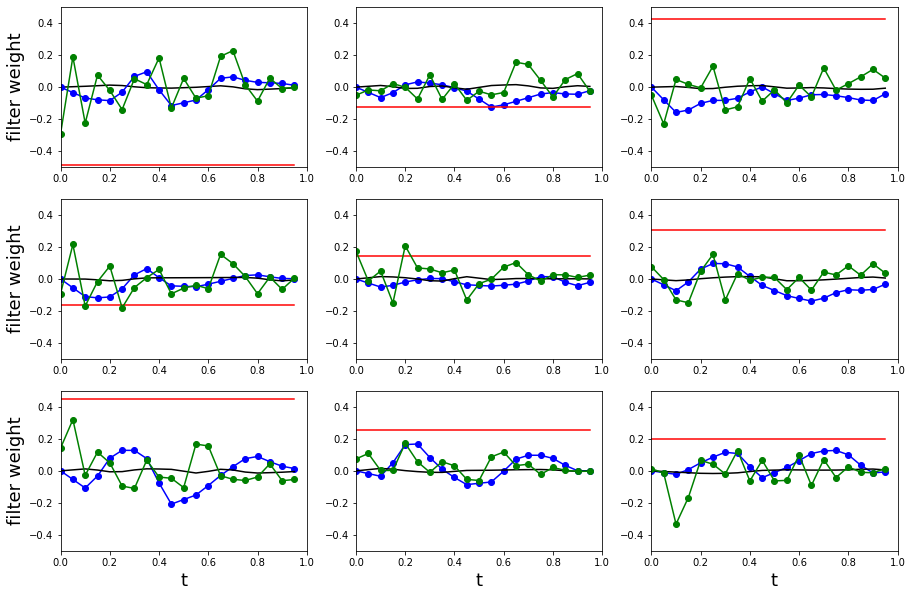

In [21]:
PlotByEle(13,12,c1,1)

In [22]:
#PlotByEle(0,0,c2,2)

In [23]:
#import random
#random.seed(14)
#idx1 = random.sample(range(64),50)
#idx2 = random.sample(range(64),10)

In [24]:
#for i in idx1:
#    for j in idx2:
#        PlotByEle(i,j,c1,1)
#        plt.tight_layout()
        #plt.show()
#        plt.savefig('c1_'+str(i)+'_'+str(j)+'.pdf',format="pdf")
    

In [25]:
#PlotByEle(idx1[0],idx2[0],c2,2)
#plt.savefig('c2_1.pdf')
#plt.show()


In [26]:
#PlotByEle(idx1[0],idx2[1],c2,2)
#plt.savefig('c2_2.pdf')

In [27]:
#PlotByEle(idx1[0],idx2[2],c2,2)
#plt.savefig('c2_3.pdf')

In [28]:
#PlotByEle(idx1[1],idx2[0],c2,2)
#plt.savefig('c2_4.pdf')

In [29]:
#PlotByEle(idx1[1],idx2[1],c2,2)
#plt.savefig('c2_5.pdf')

In [30]:
#PlotByEle(idx1[1],idx2[2],c2,2)
#plt.savefig('c2_6.pdf')

In [31]:
#PlotByEle(idx1[2],idx2[0],c2,2)
#plt.savefig('c2_7.pdf')

In [32]:
#PlotByEle(idx1[2],idx2[1],c2,2)
#plt.savefig('c2_8.pdf')

In [34]:
#PlotByEle(idx1[2],idx2[2],c2,2)
#plt.savefig('c2_9.pdf')